In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
import os

os.chdir("..")

from IPython.display import display

import sklearn.model_selection
import sklearn.metrics
import sklearn.datasets
from sklearn.ensemble import GradientBoostingClassifier

from Final_Data_Prep import remove_final_dummy, get_train_test, downsample

%matplotlib inline

import sys
sys.path.append("../")

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# read in fresh copy of df
df = pd.read_pickle('total_df.pckl.gz', compression = 'gzip')

In [5]:
'''
Data Prep (consistent with ADS as seen in Final_Gradient_Boosting_Model.ipynb)

Performing prep on total_df (here called df), not decoded_df as above in LIME
'''

#put earliest 85% of cases into training df, latest 15% of cases into test df
training, test = get_train_test(df, train_size=0.85, test_size=0.15)

# passing 50 to downsample function means training set will have 50% positive cases
training = downsample(training, 50)

X_train = training.drop('MHI', axis=1)
y_train = training['MHI']

X_test = test.drop('MHI', axis=1)
y_test = test['MHI']

In [6]:
clf_total = GradientBoostingClassifier(random_state=42, max_depth = 3, 
                                       min_samples_leaf = 10, learning_rate=.01, 
                                       n_estimators=1000)
clf_total.fit(X_train, y_train)

# Get predictions with original classifier
y_pred = clf_total.predict(X_test)

In [13]:
# set classifier list:
list_clf = [clf_total]

# get number of classifiers
num_clf = len(list_clf)

# make stacked array of predictions on test set
preds_test = np.array([y_pred])

# set X and y for full dataset
y_all = df['MHI'].copy()
X_all = df.drop(columns=['received_date', 'MHI'], inplace=False)

X_all_list = [X_all]

# initialize 2-d predictions arrays to 0
preds_all = np.zeros([num_clf, len(y_all)])

# get predictions on whole dataset
for i, clf in enumerate(list_clf):

    # get predictions on entire dataset
    preds_all[i] = clf.predict(X_all_list[i])

In [14]:
def di_actual_and_pred(X, y_true, y_pred, col, priv_class):
    '''
    Calculate disparate impact in actual data and in classifier predictions
    DI = Pr(MHI==1|non-privileged class) / Pr(MHI==1| privileged class)
       = (# positive outcomes in the non-privileged class / # non-privileged)
           / (# positive outcomes in the privileged class / # privileged)

    X: features
    y_true: actual labels
    y_pred: 2-d array of labels predicted by different classifiers
    col: category (e.g. race, gender)
    priv_class: privileged class (e.g. white, male)
    '''
    
    # get number of classifiers
    num_clf = y_pred.shape[0]

    # set privileged column
    priv_col = col+'_'+priv_class

    # get number of privileged
    priv = X[X[priv_col]==1]
    num_priv = len(priv)

    # get number of privileged with actual positive
    ind_priv = priv.index
    y_priv = y_true.loc[ind_priv]
    true_num_pos_priv = y_priv.sum()

    # get number of non-privileged
    nonpriv = X[X[priv_col]==0]
    num_nonpriv = len(nonpriv)

    # get number of non-privileged with actual positive
    ind_nonpriv = nonpriv.index
    y_nonpriv = y_true.loc[ind_nonpriv]
    true_num_pos_nonpriv = y_nonpriv.sum()
    
    # get ilocs for actual positives in each class
    priv_ilocs = y_true.index.get_indexer_for((ind_priv))
    nonpriv_ilocs = y_true.index.get_indexer_for((ind_nonpriv))

    # get DI in original data
    DI_original = (true_num_pos_nonpriv / num_nonpriv) / (true_num_pos_priv / num_priv)
    print('Disparate impact on {} in original data: {}'.format(col, round(DI_original, 4)))
    
    # initialize DI_pred to array of 1s
    DI_pred = np.ones([num_clf])
    
    # calculate DI in predictions for each classifier
    for i in range(num_clf):
        
        # get number of privileged with positive prediction
        pred_num_pos_priv = y_pred[i][priv_ilocs].sum()

        # get number of non-privileged with positive prediction
        pred_num_pos_nonpriv = y_pred[i][nonpriv_ilocs].sum()

        # get DI in predictions
        DI_pred[i] = (pred_num_pos_nonpriv / num_nonpriv) / (pred_num_pos_priv / num_priv)
        print('Disparate impact on {} in classifier {} predictions: {}'.format(col, i+1, round(DI_pred[i], 4)))
    
    return DI_original, DI_pred

In [15]:
# get DI measures

print('Test Set')
di_race_og_test, di_race_pred_test = di_actual_and_pred(X_test, y_test, preds_test, 'race', 'white')
di_gender_og_test, di_gender_pred_test = di_actual_and_pred(X_test, y_test, preds_test, 'gender', 'male')

print('\nEntire Dataset')
di_race_og_all, di_race_pred_all = di_actual_and_pred(X_all, y_all, preds_all, 'race', 'white')
di_gender_og_all, di_gender_pred_all = di_actual_and_pred(X_all, y_all, preds_all, 'gender', 'male')

Test Set
Disparate impact on race in original data: 0.5719
Disparate impact on race in classifier 1 predictions: 0.5192
Disparate impact on gender in original data: 2.4247
Disparate impact on gender in classifier 1 predictions: 3.2531

Entire Dataset
Disparate impact on race in original data: 0.4569
Disparate impact on race in classifier 1 predictions: 0.5289
Disparate impact on gender in original data: 3.5604
Disparate impact on gender in classifier 1 predictions: 3.1462


In [16]:
# put DI measures into dataframe
# Note: Master Notebook contains additional classifiers


multi_index = pd.MultiIndex.from_product([['Test Set', 'All Data'],
                                          ['Actual',
                                           'Predictions']])

race_list = [di_race_og_test, di_race_pred_test[0], 
             di_race_og_all, di_race_pred_all[0]]

gender_list = [di_gender_og_test, di_gender_pred_test[0],
               di_gender_og_all, di_gender_pred_all[0]]


di_df = pd.DataFrame(data={'Race':[round(x, 4) for x in race_list], 
                           'Gender':[round(x, 4) for x in gender_list]}, 
                     index=multi_index)

di_df

Race  Gender
Test Set Actual       0.5719  2.4247
         Predictions  0.5192  3.2531
All Data Actual       0.4569  3.5604
         Predictions  0.5289  3.1462

In [17]:
di_melt = di_df.copy()
di_melt['Dataset'] = di_melt.index.map(lambda x: str(x)[1:-1].replace("\'", ""))
di_melt = di_melt.melt(id_vars=['Dataset'], 
                  value_vars=['Race', 'Gender'])

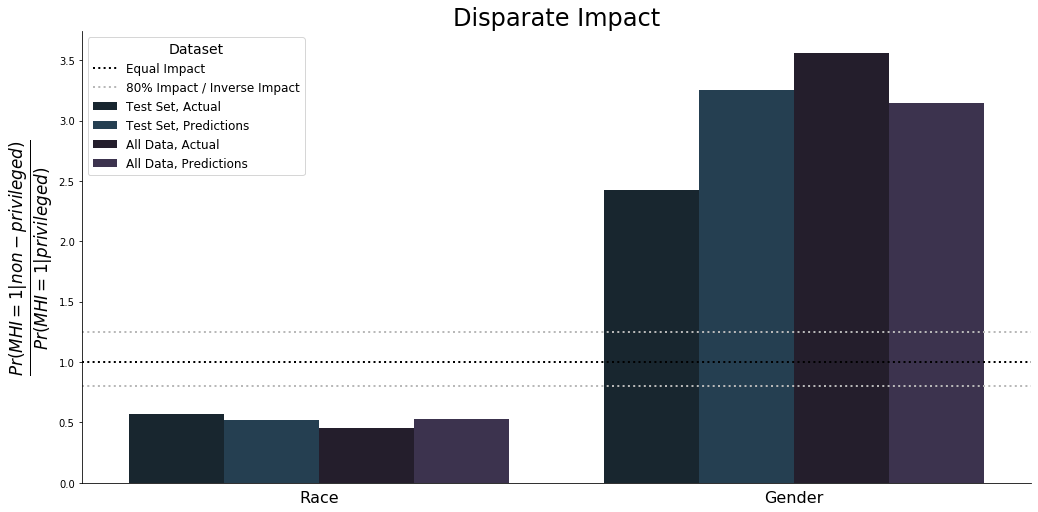

In [19]:
'''
Disparate Impact Plot
Note: Master Notebook contains additional classifiers
'''

# Create an array with the colors for plot
colors = ['#142733', '#1d4159', '#231c2e', '#3b2f52']


# plot DI
di_plot = sns.catplot(data=di_melt, 
                          x='variable', y='value', hue='Dataset', palette=sns.color_palette(colors),
                          kind='bar', aspect=2, height=7, legend_out=False)

# plot lines to show equal impact / 80% impact
plt.axhline(1, color='black', linestyle='dotted', linewidth=2, label='Equal Impact')
plt.axhline(0.8, color='#b8b8b8', linestyle='dotted', linewidth=2, label='80% Impact / Inverse Impact')
plt.axhline((1/0.8), color='#b8b8b8', linestyle='dotted', linewidth=2)

plt.tick_params(axis='x', which='both',bottom=False, top=False)
di_plot.axes[0][0].set_xlabel('')
di_plot.axes[0][0].set_xticklabels(['Race', 'Gender'], fontsize=16)
di_plot.axes[0][0].set_ylabel(r'$\frac{Pr(MHI=1|non-privileged)}{Pr(MHI=1| privileged)}$', 
                              fontsize=24)

plt.legend(title='Dataset', fontsize=12, title_fontsize=14)
plt.title('Disparate Impact', fontsize=24)
plt.show()

In [335]:
# group race designations

race_dict_with_unknown = {'Hispanic or Latino': ['race_hispanic', 
                                    'race_white [hispanic or latino]', 
                                    'race_white/black [hispanic or latino]'], 
                          'Black*': ['race_black'],
                          'White*': ['race_white'], 
                          'Asian*': ['race_asian'], 
                          'American Indian*': ['race_american indian'], 
                          'Two or More*': ['race_biracial'], 
                          'Unknown': ['race_unknown', 'race_albino']}

X_test_grouped = X_test.copy()

grouped_cols = []

for key, col_list in race_dict_with_unknown.items():
    # initialize grouped column to 0
    X_test_grouped['race (grouped)_{}'.format(key)]=0
    
    # get all indices for this group
    index_groups = [list(X_test_grouped[X_test_grouped[x]==1].index) \
                            for x in col_list]
    mask = list(itertools.chain(*index_groups))
    
    # set race_grouped column to 1 for those indices
    X_test_grouped.loc[mask, 'race (grouped)_{}'.format(key)]=1
    
    # add col to list of grouped race cols
    grouped_cols.append('race (grouped)_{}'.format(key))

In [342]:
def plain_group(x):
    '''
    Return title-case group name, 
    without category or underscore
    '''
    split = x.split('_', 1)
    if len(split)==1:
        return split[0].title()
    if len(split)==2:
        if ' or ' not in split[1]:
            return split[1].title()
        return ' or '.join([x.title() for x in split[1].split(' or ')])
    return 


def split_groups(x, cat):
    '''
    For intersectional analysis.
    Return title-case group name, 
    without category or underscore
    '''

    if x=='Overall':
        return 'All'
    
    halves = x.split(', and ', 1)
    if len(halves)<2:
        all_blanks = halves[0].split(', All ')
        if all_blanks[1][:-1]==cat:
            return 'All'
        equals = all_blanks[0].split(' = ', 1)
        if equals[0]==cat:
            return equals[1].title()
        print('Error! Got to the end of the all blanks path.')
    else:
        for half in halves:
            equals = half.split(' = ', 1)
            if equals[0]==cat:
                return equals[1].title()
        print('Error! Got to the end of the double path.')
                
    print('Error! Got to the end of the function.')
    return 


def get_stats(X_sub, col):
    
    # get target variable subset
    ind = X_sub.index
    y_sub = y_test[ind]
    
    # for subset, get predictions and probabilities for positive class 
    pred_sub = clf_total.predict(X_sub.drop(columns=grouped_cols))
    pred_proba_sub = clf_total.predict_proba(X_sub.drop(columns=grouped_cols))
    
    # get FPR, TPR
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_sub, pred_proba_sub[:,1])
    
    # get confusion matrix
    confmat_sub = sklearn.metrics.confusion_matrix(y_sub, pred_sub, labels=[1,0])
    tp = confmat_sub[0,0] # number of true positives
    fp = confmat_sub[1,0] # number of false positives
    fn = confmat_sub[0,1] # number of false negatives
    tn = confmat_sub[1,1] # number of true negatives
    
    # create dataframe with stats
    stats = pd.DataFrame(data={col:[len(pred_sub), # group size
                                    round(fp/(fp+tn), 4), # fpr
                                    round(tp/(tp+fn), 4), # recall
                                    round(sklearn.metrics.auc(fpr, tpr), 4), # auc 
                                    round((tp+tn)/len(pred_sub), 4), # accuracy
                                   ]}, 
                 index=['Test Set Group Size (N)',
                        'FPR', 'Recall', 'AUC', 'Accuracy'])
    # transpose df
    stats = stats.T
    stats['Test Set Group Size (N)'] = stats['Test Set Group Size (N)'].astype(int)
    
    # display dataframe with stats
    display(stats)
    
    #plot confusion matrix
    sklearn.metrics.plot_confusion_matrix(clf_total, X_sub.drop(columns=grouped_cols), y_sub, labels=[1,0])
    plt.show()
    
    print('\n')
    
    # return dataframe with stats
    return stats
    
    
def subgroup_stats(category1, category2=None, age_bins=None):
    '''
    Takes in 1 or 2 pre-OHE column names (e.g., 'race' and 'gender').
    If 2 categories given, produces intersectional statistics.
    
    Note: Does not support intersectional analysis with age.
    '''
    # get list of OHE columns for category 1
    if category1 != 'age_at_incident':
        cols_1 = [x for x in X_test_grouped.columns if x.startswith(category1+'_')]
    
    # intersectional analysis
    if category2 !=None:
        assert category1!='age_at_incident' and category2!='age_at_incident', \
                                         'Intersectional analysis not supported for age'
        
        # Take only the 1st word of each category
        cat1 = category1.split(' ')[0].title()
        cat2 = category2.split(' ')[0].title()
        
        # get overall stats
        total_stats = get_stats(X_test_grouped, 'Overall')
        
        # get list of OHE columns for category 1
        cols_2 = [x for x in X_test_grouped.columns if x.startswith(category2+'_')]
        
        # Get overall stats for each value of category 2
        for y in cols_2:
            X_sub = X_test_grouped[X_test_grouped[y]==1]
            if len(X_sub)==0:
                print(y,'\n\t No members of this subgroup present in the test set. \n')
            else:
                sub_stats = get_stats(X_sub, '{} = {}, All {}s'.format(cat2,
                                                                       plain_group(y),
                                                                       cat1))
                total_stats = pd.concat([total_stats, sub_stats])
        
        for x in cols_1:
            # for each value of category 1, create subset
            X_sub = X_test_grouped[X_test_grouped[x]==1]
            
            # continue if subset is empty
            if len(X_sub)==0:
                print(x,'\n\t No members of this subgroup present in the test set. \n')
                continue
            
            # process subset if not empty
            else:
                # Get overall stats for each value of category 1
                sub_stats = get_stats(X_sub, '{} = {}, All {}s'.format(cat1,
                                                                       plain_group(x),
                                                                       cat2))
                total_stats = pd.concat([total_stats, sub_stats])
                
                for y in cols_2:
                    # create sub-subset for each value of category 2
                    X_sub = X_test_grouped[X_test_grouped[x]==1]
                    X_sub = X_sub[X_sub[y]==1]
                    if len(X_sub)==0:
                        print(x+' and '+y,
                              '\n\t No members of this subgroup present in the test set. \n')
                    else:
                        # get stats if sub-subset not empty
                        sub_stats = get_stats(X_sub, '{} = {}, and {} = {}'.format(cat1, 
                                                                                  plain_group(x), 
                                                                                  cat2,
                                                                                  plain_group(y)))
                        total_stats = pd.concat([total_stats, sub_stats])
                        
        # Create category columns with plain group names
        total_stats[cat1] = total_stats.index.to_series().apply(split_groups, args=(cat1,))
        total_stats[cat2] = total_stats.index.to_series().apply(split_groups, args=(cat2,))

        # Set category column to index
        total_stats.set_index([cat1, cat2], inplace=True, drop=True)
                        
    # single trait only
    else:
        total_stats = pd.DataFrame()
        if category1 != 'age_at_incident':
            for x in cols_1:
                # for each value of category 1, create subset
                X_sub = X_test_grouped[X_test_grouped[x]==1]
                if len(X_sub)==0:
                    print(x,'\n\t No members of this subgroup present in the test set. \n')
                else:
                    # get stats if subset not empty
                    sub_stats = get_stats(X_sub, plain_group(x))
                    total_stats = pd.concat([total_stats, sub_stats])
                    
             # Get capitalized 1st word of category (e.g. "Gender")
            cat = category1.split(' ')[0].title()

            # Create category column with plain group names
            total_stats[cat]=total_stats.index

            # Set category column to index
            total_stats.set_index(cat, inplace=True, drop=True)
            
            # sort by group size
            total_stats.sort_values(by='FPR', ascending=True, inplace=True)

        # special method for age
        else:
            # cut age into bins
            cut = pd.cut(X_test_grouped['age_at_incident'], 
                         bins=age_bins, 
                         labels=False, right=False, retbins=True)
            
            # save age_at_incident encoded by bin numbers
            age_binned = cut[0]
            
            # save bins
            bins = cut[1]
            
            for x in sorted(age_binned.unique()):
                # create subset for each bin
                this_bin = age_binned[age_binned==x].index
                X_sub = X_test_grouped.loc[this_bin]
                
                # create bin labels
                edges = '{}-{}'.format(int(bins[int(x)]), int(bins[int(x)+1]-1))
                if bins[int(x)] == bins[int(x)+1]-1:
                    # if bin contains only 1 age, change label to single number
                    edges = str(int(bins[int(x)]))
            
                if len(X_sub)==0:
                    if not np.isnan(x):
                        print(x,
                              '\n\t No members of this subgroup present in the test set. \n')
                else:
                    # get stats if subset not empty
                    sub_stats = get_stats(X_sub, edges)
                    total_stats = pd.concat([total_stats, sub_stats])
                    
            # Create category column with plain group names
            total_stats['Age']=total_stats.index

            # Set category column to index
            total_stats.set_index('Age', inplace=True, drop=True)
        
    display(total_stats)
    print('\n')
    
    return total_stats

In [337]:
# set non-sequential colors for gender and race palettes

nonseq_colors = ['dark sage', "mango", "faded red", 
                 'taupe', "dusty purple",
                 "nice blue", "peachy pink"]

def plot_stats(stat_df_full, age=False):
    
    stat_df = stat_df_full
    
    stat_df.rename(columns={'Recall':'Recall\n(1-FNR)'}, inplace=True)
    
    # drop rows with NaN
    stat_df.dropna(axis=0, inplace=True)
    
    cat = stat_df.index.name
    
    # Create column with category values and test set size
    stat_df[cat] = stat_df.index + ', N=' + \
                        stat_df['Test Set Group Size (N)'].astype(str)
    
    # Add line break for Hispanic/Latino
    stat_df[cat] = stat_df[cat].str.replace('Hispanic or Latino',
                                            'Hispanic or\nLatino')
    
    if age:
        # Set sequential palette
        palette=sns.cubehelix_palette(10, start=.6, rot=-.5, 
                                      dark=0.2, light=.85, reverse=True)
        
    else:
        # Set non-sequential palette
        palette=sns.xkcd_palette(nonseq_colors)

    # melt df to prepare for sns.catplot
    df_melt = stat_df.melt(id_vars=[cat], 
                  value_vars=['FPR', 'Recall\n(1-FNR)', 'AUC', 'Accuracy'])

    # plot metrics
    stat_plot = sns.catplot(data=df_melt, 
                              x='variable', y='value', hue=cat,
                              kind='bar', palette=palette,
                            aspect=1.75, height=5, legend_out=False)
    
    stat_plot.axes[0][0].set_xlabel('')
    stat_plot.axes[0][0].set_ylabel('')
    stat_plot.axes[0][0].tick_params(labelsize=12, axis='x', which='both', length=0)
    stat_plot.axes[0][0].legend(loc='upper left', title=r'$\bf{}$'.format(cat), 
                                title_fontsize=14, fontsize=11, frameon=False, framealpha=1)
    
    plt.show()
    
    return

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
17-25,12820,0.177,0.6429,0.8111,0.822


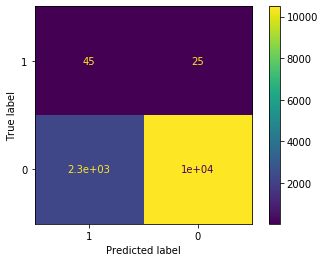

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
26-49,23417,0.253,0.8514,0.8609,0.7477


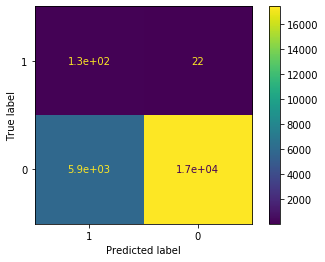

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
50-82,7126,0.2805,0.8333,0.8272,0.7202


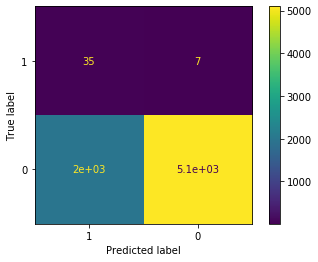

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
Age,,,,,
17-25,12820,0.1770,0.6429,0.8111,0.8220
26-49,23417,0.2530,0.8514,0.8609,0.7477
50-82,7126,0.2805,0.8333,0.8272,0.7202


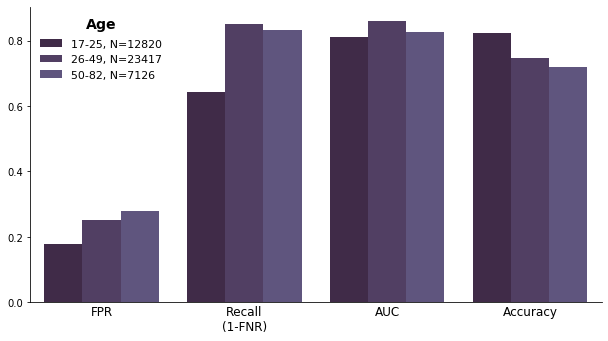

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
17-29,19733,0.1972,0.7054,0.8182,0.8023


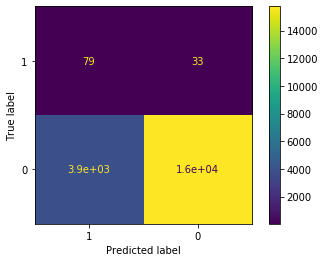

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
30-44,13269,0.2477,0.8452,0.8644,0.7529


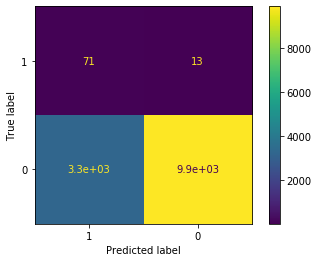

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
45-64,9768,0.2945,0.8871,0.8662,0.7067


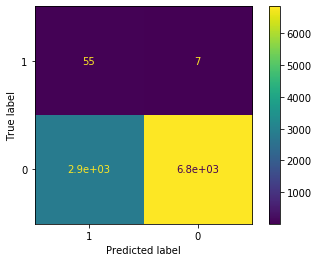

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
65-82,593,0.2335,0.5,0.5711,0.7656


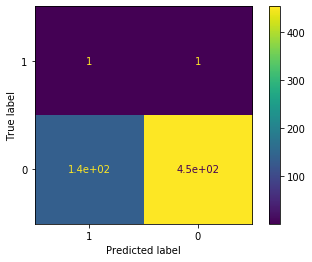

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
Age,,,,,
17-29,19733,0.1972,0.7054,0.8182,0.8023
30-44,13269,0.2477,0.8452,0.8644,0.7529
45-64,9768,0.2945,0.8871,0.8662,0.7067
65-82,593,0.2335,0.5000,0.5711,0.7656


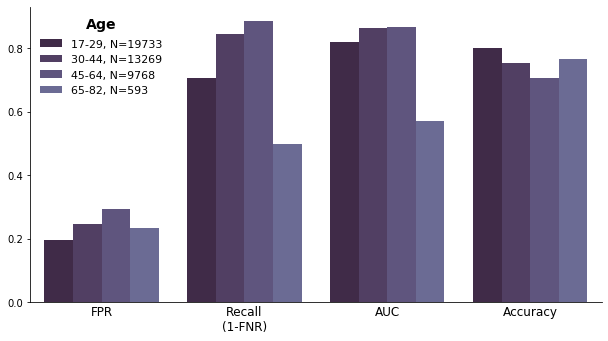

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
17-19,2623,0.1948,0.6,0.8105,0.8048


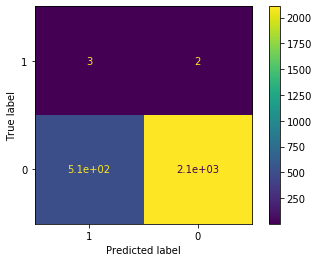

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
20-24,8430,0.169,0.6226,0.8039,0.8297


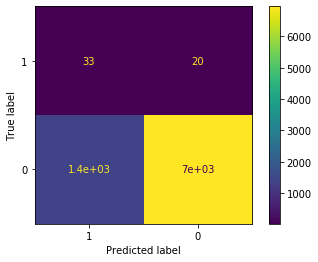

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
25-29,8680,0.2252,0.7963,0.836,0.7749


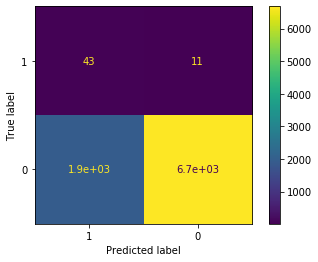

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
30-39,10114,0.2408,0.8689,0.8644,0.7598


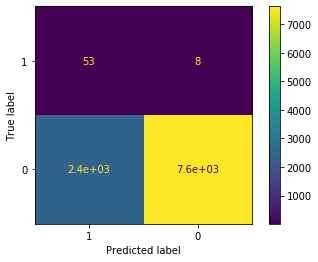

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
40-49,6390,0.2922,0.8667,0.8841,0.7089


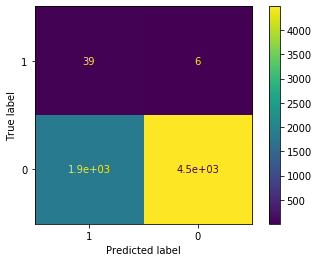

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
50-82,7126,0.2805,0.8333,0.8272,0.7202


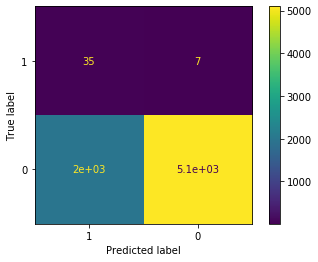

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
Age,,,,,
17-19,2623,0.1948,0.6000,0.8105,0.8048
20-24,8430,0.1690,0.6226,0.8039,0.8297
25-29,8680,0.2252,0.7963,0.8360,0.7749
30-39,10114,0.2408,0.8689,0.8644,0.7598
40-49,6390,0.2922,0.8667,0.8841,0.7089
50-82,7126,0.2805,0.8333,0.8272,0.7202


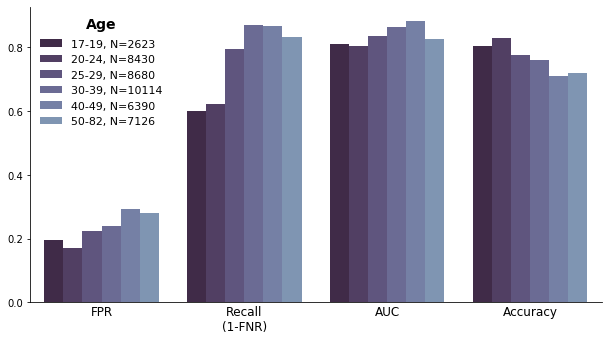

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
17-19,2623,0.1948,0.6,0.8105,0.8048


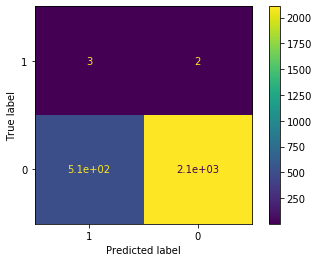

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
20-22,5022,0.1771,0.6585,0.8178,0.8216


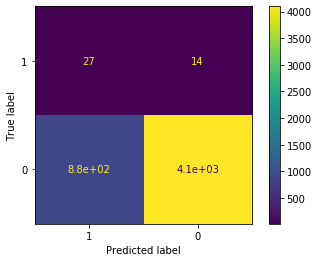

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
23-26,6977,0.1778,0.7297,0.8136,0.8217


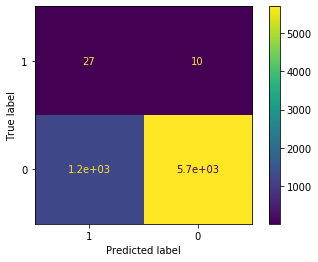

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
27-29,5111,0.2446,0.7586,0.8355,0.7554


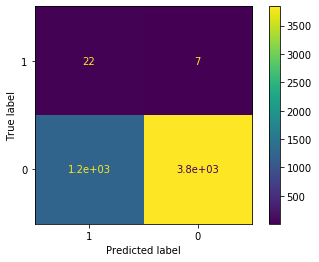

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
30-34,5800,0.2353,0.9024,0.8843,0.7657


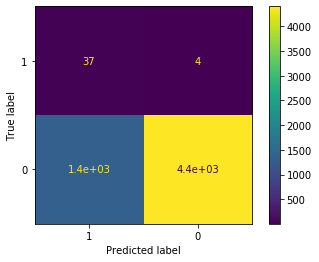

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
35-39,4314,0.2483,0.8,0.8239,0.752


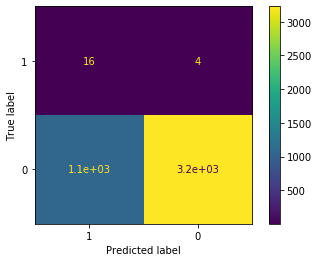

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
40-49,6390,0.2922,0.8667,0.8841,0.7089


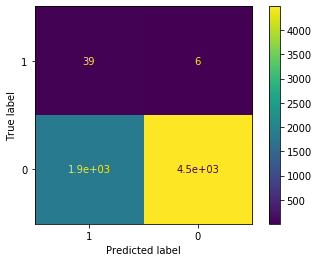

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
50-59,5296,0.2979,0.8286,0.829,0.703


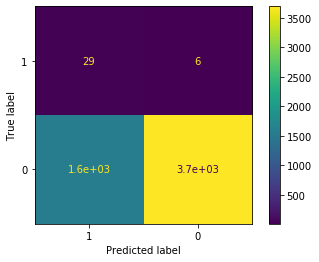

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
60-82,1830,0.2304,0.8571,0.8102,0.7699


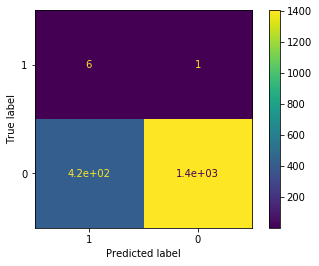

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
Age,,,,,
17-19,2623,0.1948,0.6000,0.8105,0.8048
20-22,5022,0.1771,0.6585,0.8178,0.8216
23-26,6977,0.1778,0.7297,0.8136,0.8217
27-29,5111,0.2446,0.7586,0.8355,0.7554
30-34,5800,0.2353,0.9024,0.8843,0.7657
35-39,4314,0.2483,0.8000,0.8239,0.7520
40-49,6390,0.2922,0.8667,0.8841,0.7089
50-59,5296,0.2979,0.8286,0.8290,0.7030
60-82,1830,0.2304,0.8571,0.8102,0.7699


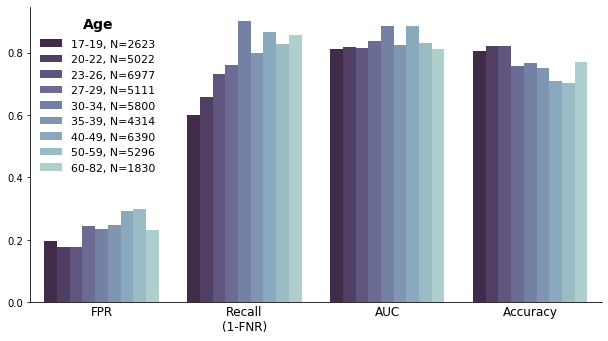

In [338]:
age_min = X_test_grouped['age_at_incident'].min()
age_max = X_test_grouped['age_at_incident'].max()

# US age divisions
age_stats_1 = subgroup_stats('age_at_incident', age_bins=[age_min, 26, 50, age_max+1])
plot_stats(age_stats_1, age=True)

# Chicago age divisions
age_stats_2 = subgroup_stats('age_at_incident', age_bins=[age_min, 30, 45, 65, age_max+1])
plot_stats(age_stats_2, age=True)

# Medium number of bins
age_stats_3 = subgroup_stats('age_at_incident', age_bins=[age_min, 20, 25, 30, 40, 50, age_max+1])
plot_stats(age_stats_3, age=True)

# Large number of bins
age_stats_4 = subgroup_stats('age_at_incident', age_bins=[age_min, 20, 23, 27, 30, 35, 40, 50, 60, age_max+1])
plot_stats(age_stats_4, age=True)


,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
Female,5582,0.6101,0.9296,0.8228,0.3968


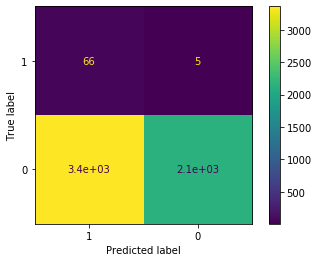

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
Male,37546,0.1802,0.7407,0.8395,0.8194


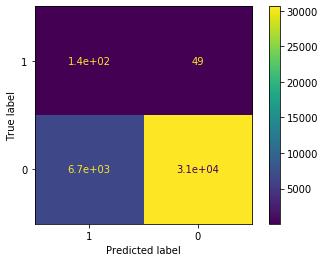

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
Unknown,235,0.1532,NaN,NaN,0.8468


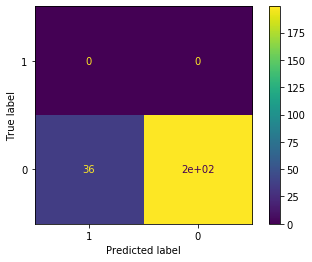

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
Gender,,,,,
Unknown,235,0.1532,NaN,NaN,0.8468
Male,37546,0.1802,0.7407,0.8395,0.8194
Female,5582,0.6101,0.9296,0.8228,0.3968


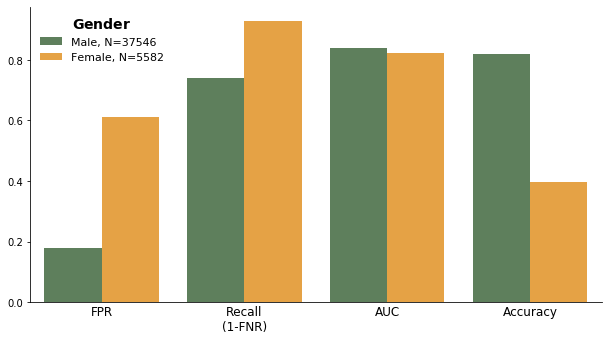

In [339]:
gender_stats = subgroup_stats('gender')
plot_stats(gender_stats)

race_albino 
	 No members of this subgroup present in the test set. 



,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
American Indian,7,0.7143,NaN,NaN,0.2857


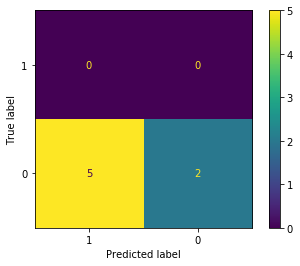

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
Asian,224,0.3122,1.0,0.8612,0.692


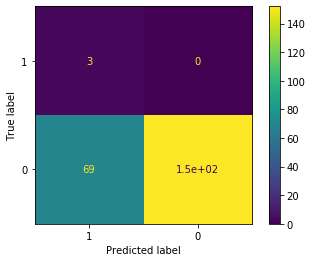

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
Biracial,5,0.2,NaN,NaN,0.8


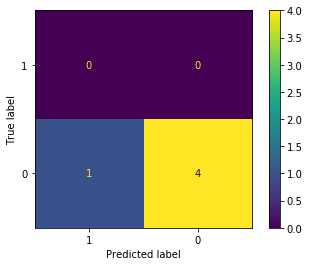

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
Black,29269,0.2111,0.7738,0.8407,0.7889


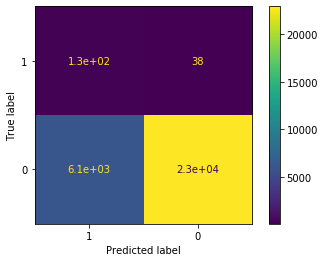

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
Hispanic,446,0.1056,1.0,0.9933,0.8946


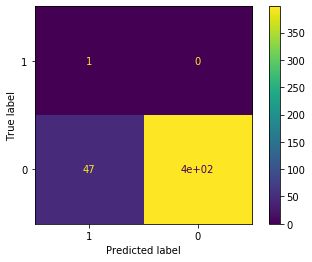

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
Unknown,420,0.181,NaN,NaN,0.819


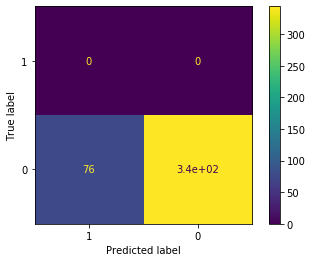

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
White,6000,0.4023,0.8947,0.8423,0.6005


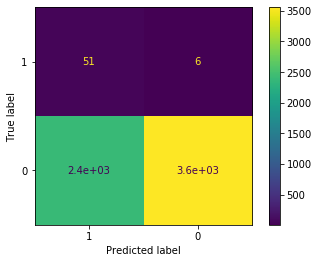

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
White [Hispanic or Latino],6751,0.2004,0.6552,0.7919,0.799


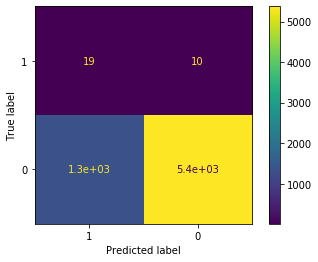

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
White/Black [Hispanic or Latino],241,0.2218,1.0,1.0,0.7801


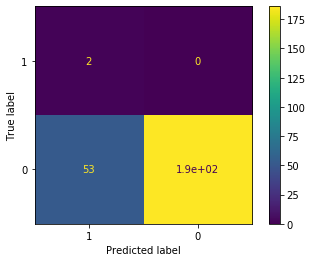

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
Race,,,,,
Hispanic,446,0.1056,1.0000,0.9933,0.8946
Unknown,420,0.1810,NaN,NaN,0.8190
Biracial,5,0.2000,NaN,NaN,0.8000
White [Hispanic or Latino],6751,0.2004,0.6552,0.7919,0.7990
Black,29269,0.2111,0.7738,0.8407,0.7889
White/Black [Hispanic or Latino],241,0.2218,1.0000,1.0000,0.7801
Asian,224,0.3122,1.0000,0.8612,0.6920
White,6000,0.4023,0.8947,0.8423,0.6005
American Indian,7,0.7143,NaN,NaN,0.2857


,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
Hispanic or Latino,7438,0.1954,0.6875,0.8128,0.8041


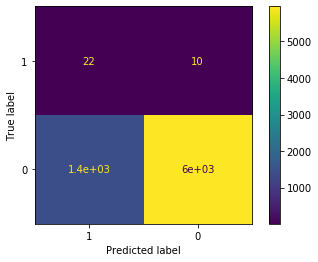

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
Black*,29269,0.2111,0.7738,0.8407,0.7889


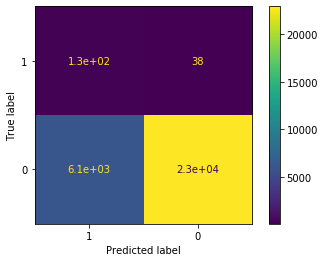

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
White*,6000,0.4023,0.8947,0.8423,0.6005


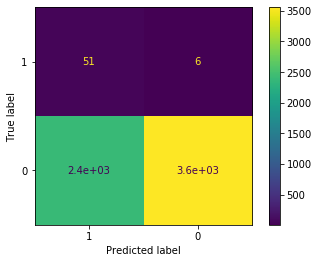

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
Asian*,224,0.3122,1.0,0.8612,0.692


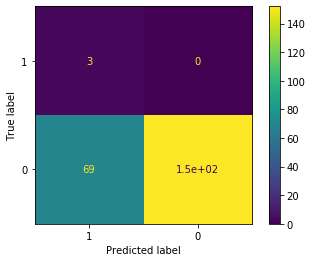

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
American Indian*,7,0.7143,NaN,NaN,0.2857


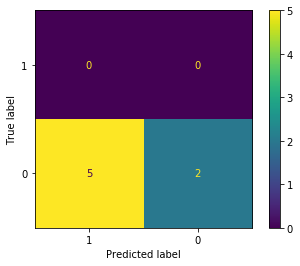

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
Two or More*,5,0.2,NaN,NaN,0.8


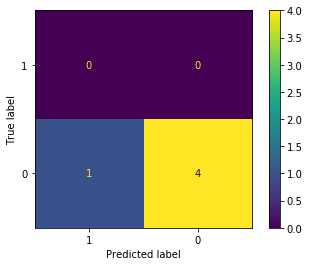

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
Unknown,420,0.181,NaN,NaN,0.819


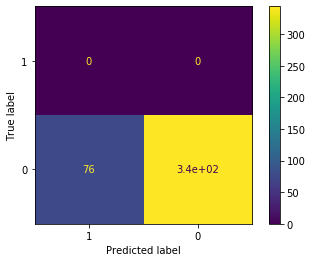

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
Race,,,,,
Unknown,420,0.1810,NaN,NaN,0.8190
Hispanic or Latino,7438,0.1954,0.6875,0.8128,0.8041
Two or More*,5,0.2000,NaN,NaN,0.8000
Black*,29269,0.2111,0.7738,0.8407,0.7889
Asian*,224,0.3122,1.0000,0.8612,0.6920
White*,6000,0.4023,0.8947,0.8423,0.6005
American Indian*,7,0.7143,NaN,NaN,0.2857


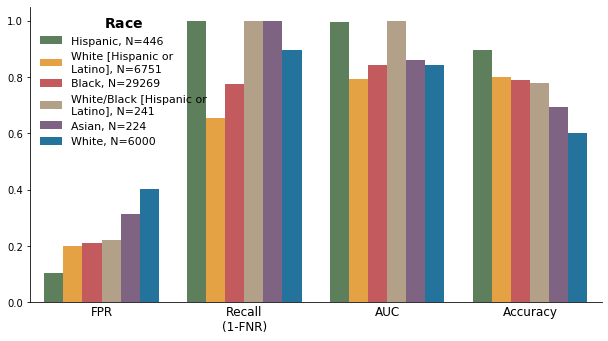

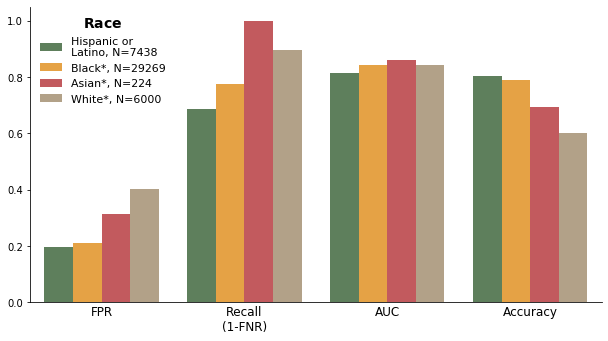

In [340]:
race_stats = subgroup_stats('race')
grouped_race_stats = subgroup_stats('race (grouped)')
plot_stats(race_stats)
plot_stats(grouped_race_stats)

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
Overall,43363,0.235,0.7923,0.8411,0.7651


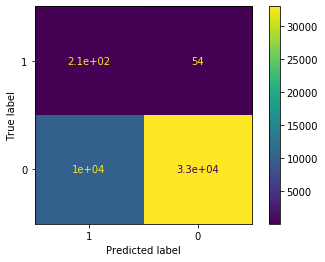

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
"Gender = Female, All Races",5582,0.6101,0.9296,0.8228,0.3968


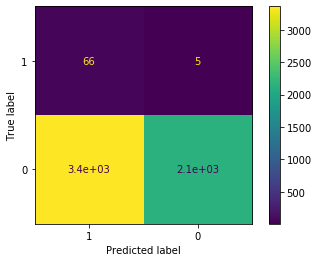

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
"Gender = Male, All Races",37546,0.1802,0.7407,0.8395,0.8194


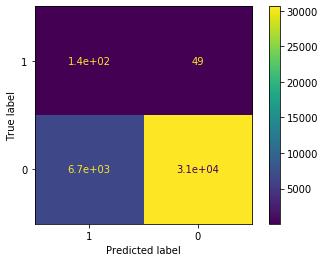

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
"Gender = Unknown, All Races",235,0.1532,NaN,NaN,0.8468


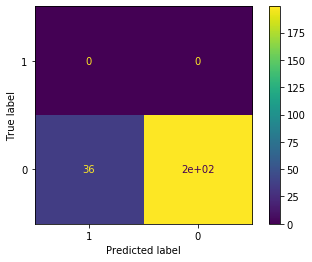



race_albino 
	 No members of this subgroup present in the test set. 



,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
"Race = American Indian, All Genders",7,0.7143,NaN,NaN,0.2857


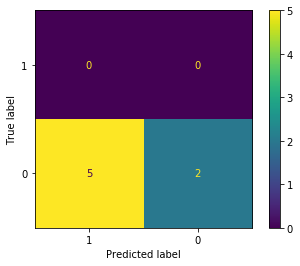

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
"Race = American Indian, and Gender = Female",3,1.0,NaN,NaN,0.0


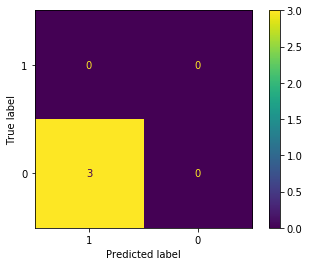

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
"Race = American Indian, and Gender = Male",4,0.5,NaN,NaN,0.5


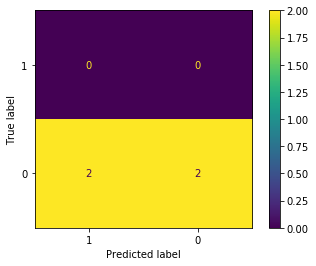



race_american indian and gender_unknown 
	 No members of this subgroup present in the test set. 



,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
"Race = Asian, All Genders",224,0.3122,1.0,0.8612,0.692


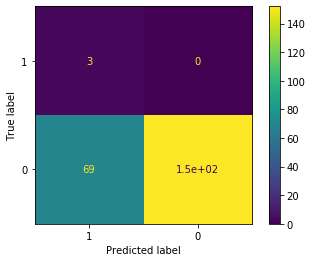

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
"Race = Asian, and Gender = Female",39,0.6842,1.0,0.9474,0.3333


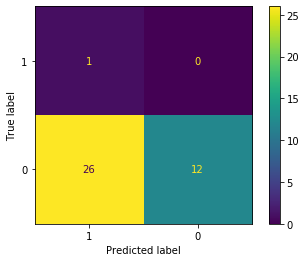

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
"Race = Asian, and Gender = Male",185,0.235,1.0,0.8634,0.7676


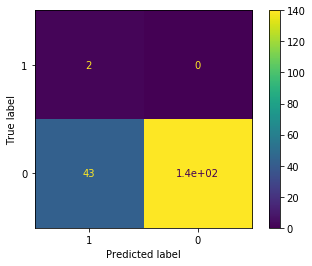



race_asian and gender_unknown 
	 No members of this subgroup present in the test set. 



,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
"Race = Biracial, All Genders",5,0.2,NaN,NaN,0.8


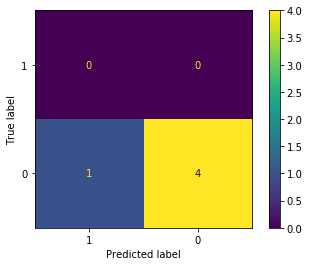



race_biracial and gender_female 
	 No members of this subgroup present in the test set. 



,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
"Race = Biracial, and Gender = Male",5,0.2,NaN,NaN,0.8


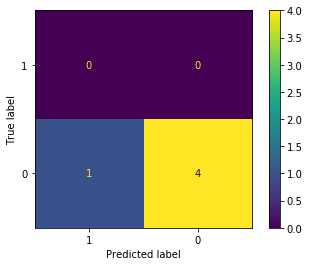



race_biracial and gender_unknown 
	 No members of this subgroup present in the test set. 



,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
"Race = Black, All Genders",29269,0.2111,0.7738,0.8407,0.7889


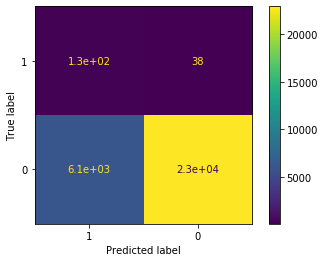

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
"Race = Black, and Gender = Female",3424,0.6085,0.9574,0.8187,0.3992


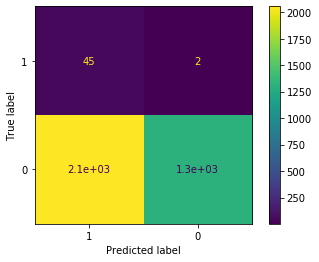

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
"Race = Black, and Gender = Male",25824,0.159,0.7025,0.8359,0.8403


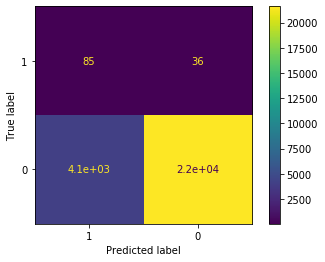

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
"Race = Black, and Gender = Unknown",21,0.0,NaN,NaN,1.0


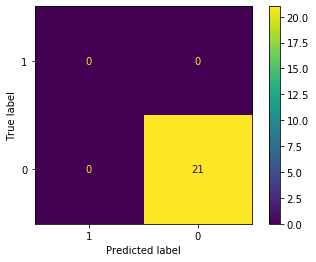

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
"Race = Hispanic, All Genders",446,0.1056,1.0,0.9933,0.8946


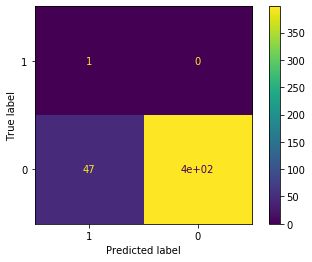

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
"Race = Hispanic, and Gender = Female",45,0.4773,1.0,0.9318,0.5333


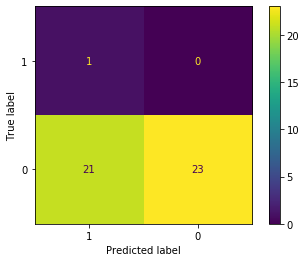

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
"Race = Hispanic, and Gender = Male",401,0.0648,NaN,NaN,0.9352


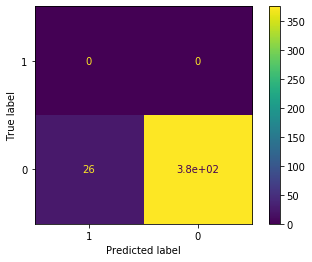



race_hispanic and gender_unknown 
	 No members of this subgroup present in the test set. 



,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
"Race = Unknown, All Genders",420,0.181,NaN,NaN,0.819


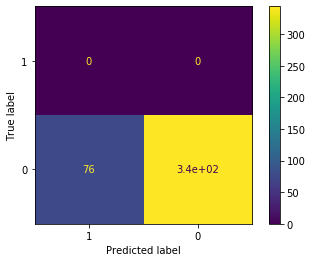

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
"Race = Unknown, and Gender = Female",34,0.5294,NaN,NaN,0.4706


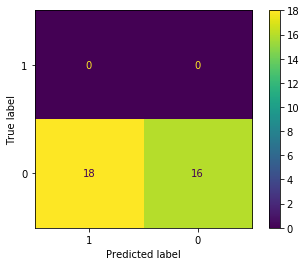

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
"Race = Unknown, and Gender = Male",178,0.1236,NaN,NaN,0.8764


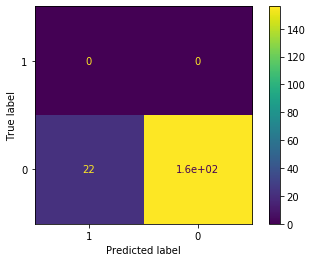

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
"Race = Unknown, and Gender = Unknown",208,0.1731,NaN,NaN,0.8269


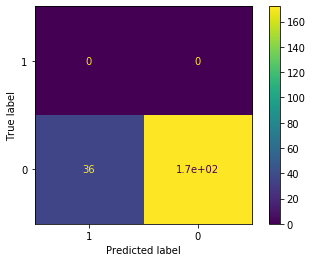

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
"Race = White, All Genders",6000,0.4023,0.8947,0.8423,0.6005


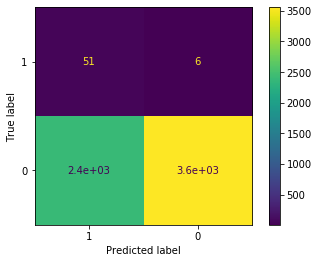

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
"Race = White, and Gender = Female",1345,0.6404,0.9231,0.8544,0.3651


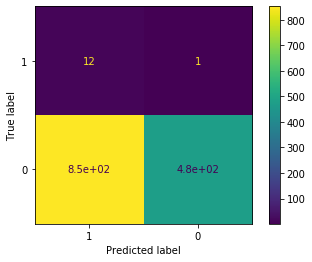

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
"Race = White, and Gender = Male",4653,0.3337,0.8864,0.855,0.6684


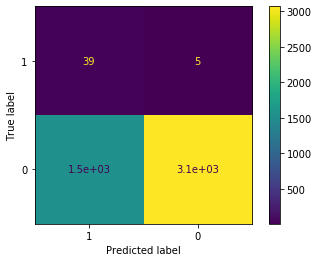

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
"Race = White, and Gender = Unknown",2,0.0,NaN,NaN,1.0


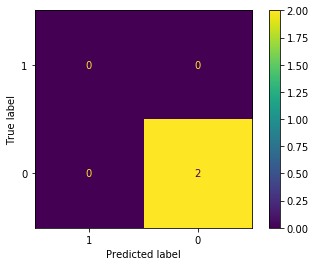

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
"Race = White [Hispanic or Latino], All Genders",6751,0.2004,0.6552,0.7919,0.799


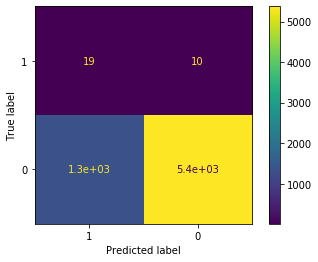

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
"Race = White [Hispanic or Latino], and Gender = Female",664,0.5616,0.7143,0.7364,0.4413


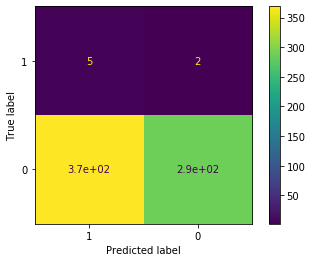

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
"Race = White [Hispanic or Latino], and Gender = Male",6083,0.1614,0.6364,0.7814,0.8379


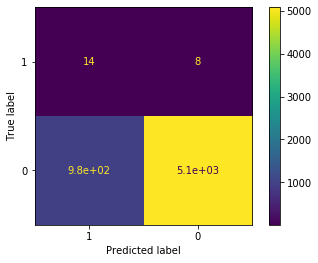

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
"Race = White [Hispanic or Latino], and Gender = Unknown",4,0.0,NaN,NaN,1.0


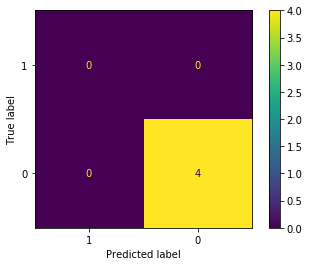

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
"Race = White/Black [Hispanic or Latino], All Genders",241,0.2218,1.0,1.0,0.7801


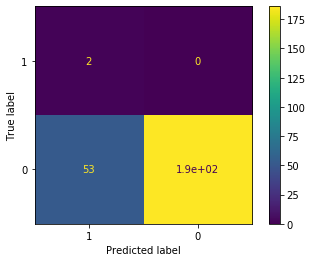

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
"Race = White/Black [Hispanic or Latino], and Gender = Female",28,0.6538,1.0,1.0,0.3929


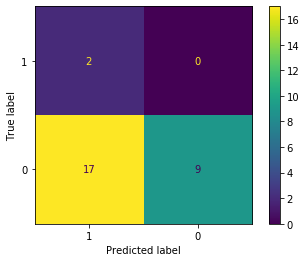

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
"Race = White/Black [Hispanic or Latino], and Gender = Male",213,0.169,NaN,NaN,0.831


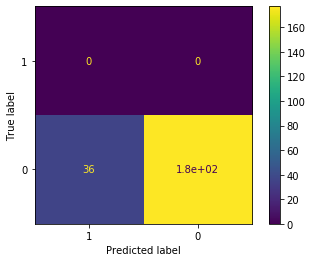



race_white/black [hispanic or latino] and gender_unknown 
	 No members of this subgroup present in the test set. 



Test Set Group Size (N)     FPR  \
Race                             Gender                                     
All                              All                        43363  0.2350   
                                 Female                      5582  0.6101   
                                 Male                       37546  0.1802   
                                 Unknown                      235  0.1532   
American Indian                  All                            7  0.7143   
                                 Female                         3  1.0000   
                                 Male                           4  0.5000   
Asian                            All                          224  0.3122   
                                 Female                        39  0.6842   
                                 Male                         185  0.2350   
Biracial                         All                            5  0.2000   
                                 Male                           5  0.2000   
Black                            All                        29269  0.2111   
                                 Female                      3424  0.6085   
                                 Male                       25824  0.1590   
                                 Unknown                       21  0.0000   
Hispanic                         All                          446  0.1056   
                                 Female                        45  0.4773   
                                 Male                         401  0.0648   
Unknown                          All                          420  0.1810   
                                 Female                        34  0.5294   
                                 Male                         178  0.1236   
                                 Unknown                      208  0.1731   
White                            All                         6000  0.4023   
                                 Female                      1345  0.6404   
                                 Male                        4653  0.3337   
                                 Unknown                        2  0.0000   
White [Hispanic Or Latino]       All                         6751  0.2004   
                                 Female                       664  0.5616   
                                 Male                        6083  0.1614   
                                 Unknown                        4  0.0000   
White/Black [Hispanic Or Latino] All                          241  0.2218   
                                 Female                        28  0.6538   
                                 Male                         213  0.1690   

                                          Recall     AUC  Accuracy  
Race                             Gender                             
All                              All      0.7923  0.8411    0.7651  
                                 Female   0.9296  0.8228    0.3968  
                                 Male     0.7407  0.8395    0.8194  
                                 Unknown     NaN     NaN    0.8468  
American Indian                  All         NaN     NaN    0.2857  
                                 Female      NaN     NaN    0.0000  
                                 Male        NaN     NaN    0.5000  
Asian                            All      1.0000  0.8612    0.6920  
                                 Female   1.0000  0.9474    0.3333  
                                 Male     1.0000  0.8634    0.7676  
Biracial                         All         NaN     NaN    0.8000  
                                 Male        NaN     NaN    0.8000  
Black                            All      0.7738  0.8407    0.7889  
                                 Female   0.9574  0.8187    0.3992  
                                 Male     0.7025  0.8359    0.8403  
                                 Unknown     NaN     NaN    1.0000  
Hispanic                   

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
Overall,43363,0.235,0.7923,0.8411,0.7651


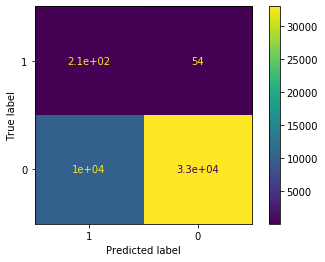

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
"Gender = Female, All Races",5582,0.6101,0.9296,0.8228,0.3968


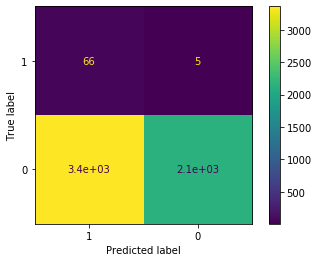

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
"Gender = Male, All Races",37546,0.1802,0.7407,0.8395,0.8194


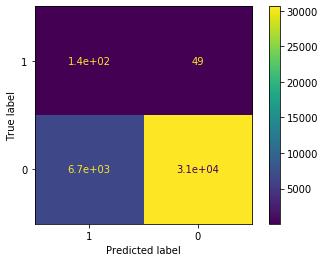

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
"Gender = Unknown, All Races",235,0.1532,NaN,NaN,0.8468


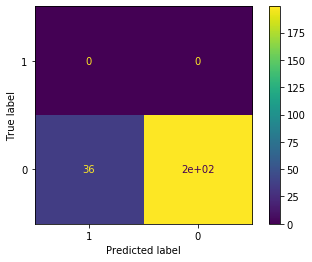

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
"Race = Hispanic or Latino, All Genders",7438,0.1954,0.6875,0.8128,0.8041


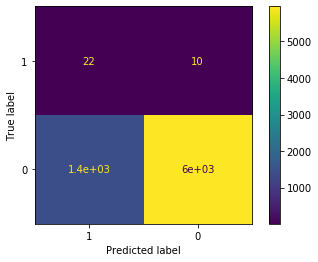

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
"Race = Hispanic or Latino, and Gender = Female",737,0.5598,0.8,0.8079,0.445


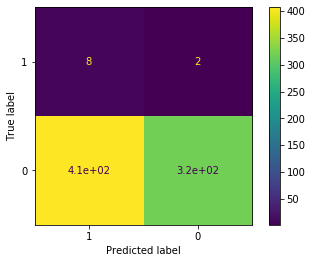

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
"Race = Hispanic or Latino, and Gender = Male",6697,0.1558,0.6364,0.7837,0.8435


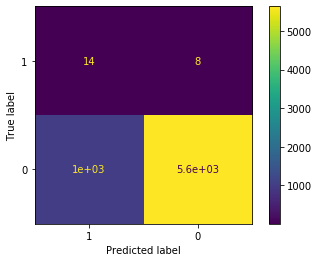

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
"Race = Hispanic or Latino, and Gender = Unknown",4,0.0,NaN,NaN,1.0


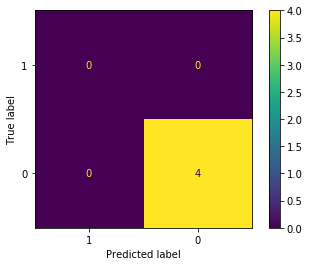

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
"Race = Black*, All Genders",29269,0.2111,0.7738,0.8407,0.7889


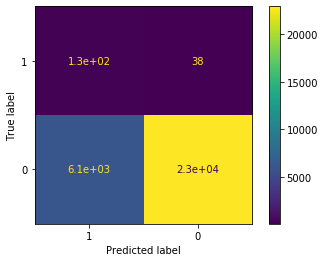

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
"Race = Black*, and Gender = Female",3424,0.6085,0.9574,0.8187,0.3992


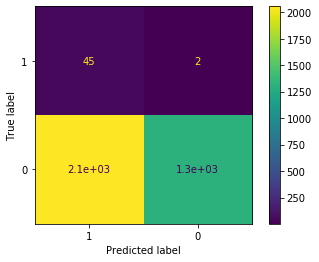

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
"Race = Black*, and Gender = Male",25824,0.159,0.7025,0.8359,0.8403


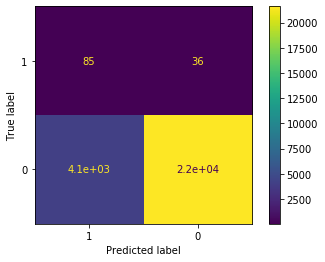

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
"Race = Black*, and Gender = Unknown",21,0.0,NaN,NaN,1.0


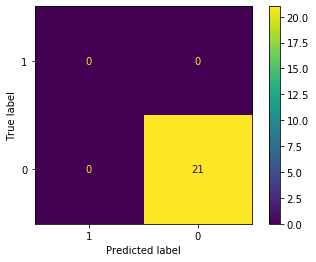

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
"Race = White*, All Genders",6000,0.4023,0.8947,0.8423,0.6005


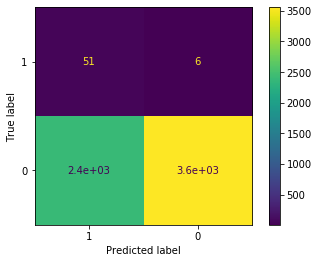

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
"Race = White*, and Gender = Female",1345,0.6404,0.9231,0.8544,0.3651


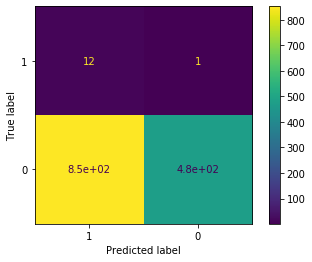

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
"Race = White*, and Gender = Male",4653,0.3337,0.8864,0.855,0.6684


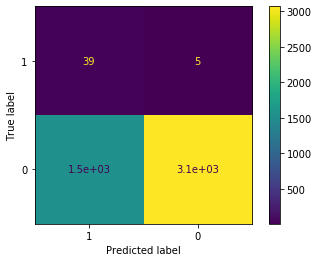

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
"Race = White*, and Gender = Unknown",2,0.0,NaN,NaN,1.0


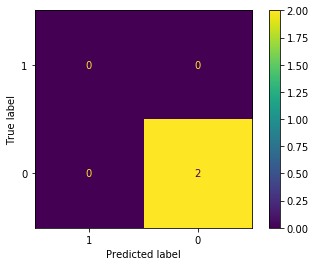

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
"Race = Asian*, All Genders",224,0.3122,1.0,0.8612,0.692


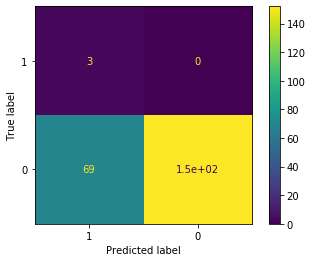

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
"Race = Asian*, and Gender = Female",39,0.6842,1.0,0.9474,0.3333


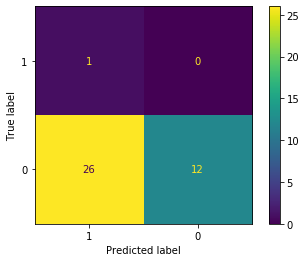

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
"Race = Asian*, and Gender = Male",185,0.235,1.0,0.8634,0.7676


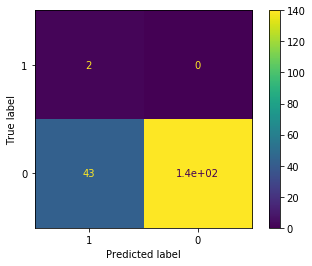



race (grouped)_Asian* and gender_unknown 
	 No members of this subgroup present in the test set. 



,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
"Race = American Indian*, All Genders",7,0.7143,NaN,NaN,0.2857


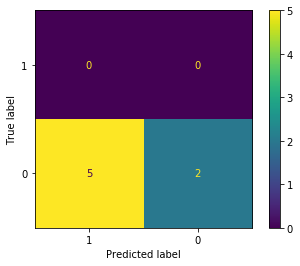

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
"Race = American Indian*, and Gender = Female",3,1.0,NaN,NaN,0.0


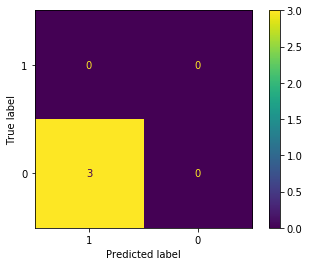

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
"Race = American Indian*, and Gender = Male",4,0.5,NaN,NaN,0.5


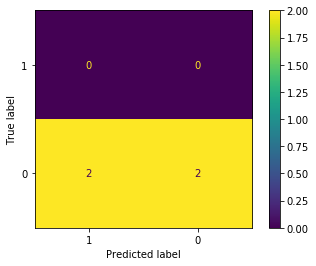



race (grouped)_American Indian* and gender_unknown 
	 No members of this subgroup present in the test set. 



,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
"Race = Two or More*, All Genders",5,0.2,NaN,NaN,0.8


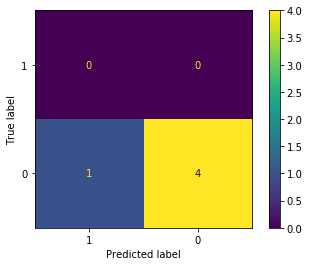



race (grouped)_Two or More* and gender_female 
	 No members of this subgroup present in the test set. 



,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
"Race = Two or More*, and Gender = Male",5,0.2,NaN,NaN,0.8


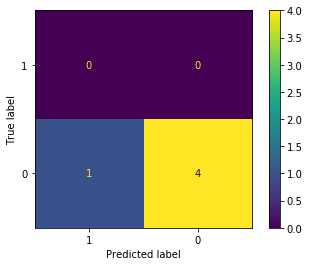



race (grouped)_Two or More* and gender_unknown 
	 No members of this subgroup present in the test set. 



,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
"Race = Unknown, All Genders",420,0.181,NaN,NaN,0.819


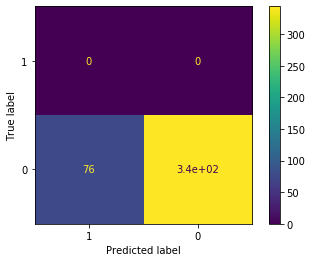

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
"Race = Unknown, and Gender = Female",34,0.5294,NaN,NaN,0.4706


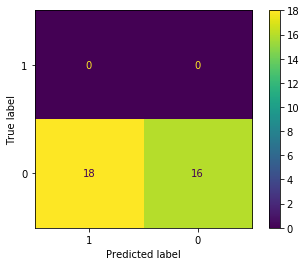

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
"Race = Unknown, and Gender = Male",178,0.1236,NaN,NaN,0.8764


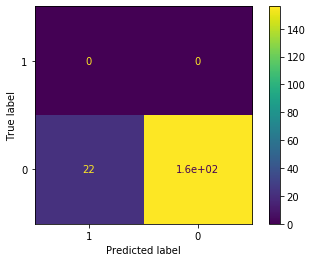

,Test Set Group Size (N),FPR,Recall,AUC,Accuracy
"Race = Unknown, and Gender = Unknown",208,0.1731,NaN,NaN,0.8269


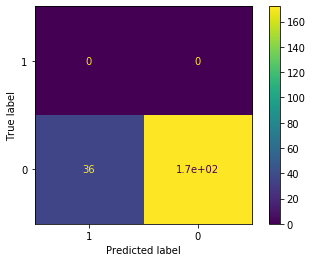

Test Set Group Size (N)     FPR  Recall     AUC  \
Race               Gender                                                     
All                All                        43363  0.2350  0.7923  0.8411   
                   Female                      5582  0.6101  0.9296  0.8228   
                   Male                       37546  0.1802  0.7407  0.8395   
                   Unknown                      235  0.1532     NaN     NaN   
Hispanic Or Latino All                         7438  0.1954  0.6875  0.8128   
                   Female                       737  0.5598  0.8000  0.8079   
                   Male                        6697  0.1558  0.6364  0.7837   
                   Unknown                        4  0.0000     NaN     NaN   
Black*             All                        29269  0.2111  0.7738  0.8407   
                   Female                      3424  0.6085  0.9574  0.8187   
                   Male                       25824  0.1590  0.7025  0.8359   
                   Unknown                       21  0.0000     NaN     NaN   
White*             All                         6000  0.4023  0.8947  0.8423   
                   Female                      1345  0.6404  0.9231  0.8544   
                   Male                        4653  0.3337  0.8864  0.8550   
                   Unknown                        2  0.0000     NaN     NaN   
Asian*             All                          224  0.3122  1.0000  0.8612   
                   Female                        39  0.6842  1.0000  0.9474   
                   Male                         185  0.2350  1.0000  0.8634   
American Indian*   All                            7  0.7143     NaN     NaN   
                   Female                         3  1.0000     NaN     NaN   
                   Male                           4  0.5000     NaN     NaN   
Two Or More*       All                            5  0.2000     NaN     NaN   
                   Male                           5  0.2000     NaN     NaN   
Unknown            All                          420  0.1810     NaN     NaN   
                   Female                        34  0.5294     NaN     NaN   
                   Male                         178  0.1236     NaN     NaN   
                   Unknown                      208  0.1731     NaN     NaN   

                            Accuracy  
Race               Gender             
All                All        0.7651  
                   Female     0.3968  
                   Male       0.8194  
                   Unknown    0.8468  
Hispanic Or Latino All        0.8041  
                   Female     0.4450  
                   Male       0.8435  
                   Unknown    1.0000  
Black*             All        0.7889  
                   Female     0.3992  
                   Male       0.8403  
                   Unknown    1.0000  
White*             All        0.6005  
                   Female     0.3651  
                   Male       0.6684  
                   Unknown    1.0000  
Asian*             All        0.6920  
                   Female     0.3333  
                   Male       0.7676  
American Indian*   All        0.2857  
                   Female     0.0000  
                   Male       0.5000  
Two Or More*       All        0.8000  
                   Male       0.8000  
Unknown            All        0.8190  
                   Female     0.4706  
                   Male       0.8764  
                   Unknown    0.8269

In [343]:
race_and_gender_stats = subgroup_stats('race', 'gender')
grouped_race_and_gender_stats = subgroup_stats('race (grouped)', 'gender')